In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from nbeats_pytorch.model import NBeatsNet
from sklearn.metrics import mean_squared_error

In [2]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install scipy
#!pip install statsmodels
#!pip install scikit-learn
#!pip install torch
#!pip install nbeats_pytorch

In [3]:
NAO_df = pd.read_csv("../../1_DatasetCharacteristics/NAO_INDEX_MONTHLY.csv")

In [4]:
NAO_df

,Date,NAO_index
0,1825-01-01,-0.226
1,1825-02-01,0.211
2,1825-03-01,0.327
3,1825-04-01,-0.276
4,1825-05-01,0.131
...,...,...
2383,2023-08-01,-1.754
2384,2023-09-01,-0.653
2385,2023-10-01,-1.229
2386,2023-11-01,-0.427


In [5]:
NAO_df['Date'] = pd.to_datetime(NAO_df['Date'])
NAO_df.set_index('Date', inplace=True)

print(NAO_df)

            NAO_index
Date                 
1825-01-01     -0.226
1825-02-01      0.211
1825-03-01      0.327
1825-04-01     -0.276
1825-05-01      0.131
...               ...
2023-08-01     -1.754
2023-09-01     -0.653
2023-10-01     -1.229
2023-11-01     -0.427
2023-12-01      0.671

[2388 rows x 1 columns]


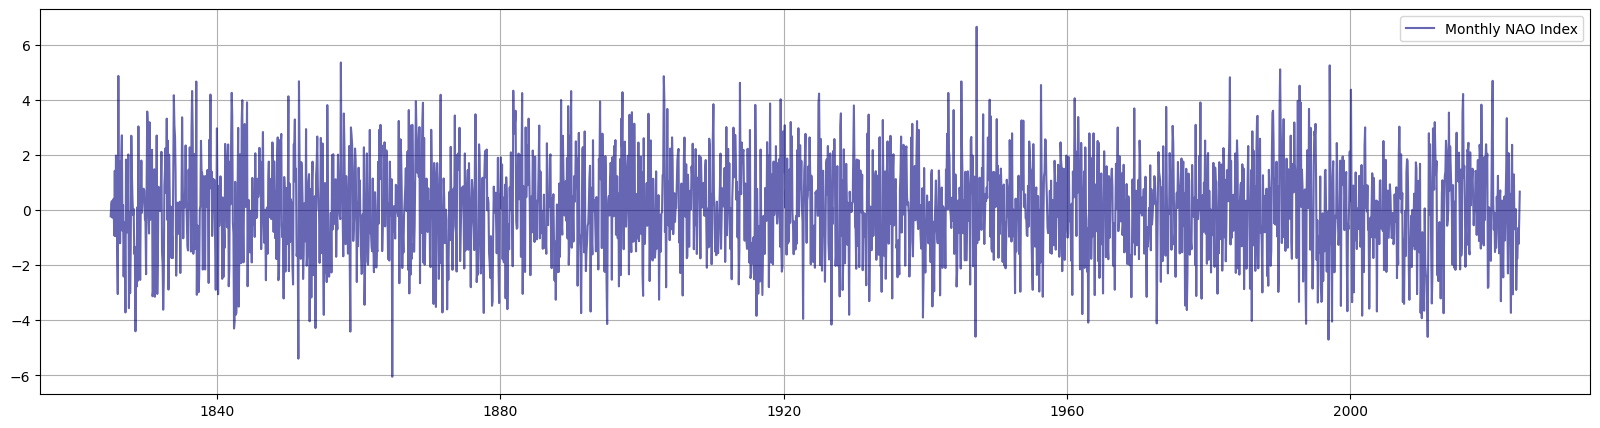

In [6]:
#simple visulization of the time series
plt.figure(figsize=[20,5])
plt.plot(NAO_df["NAO_index"],alpha=0.6,label="Monthly NAO Index",color="navy")
plt.legend()
plt.grid()

## Stochastic Analysis

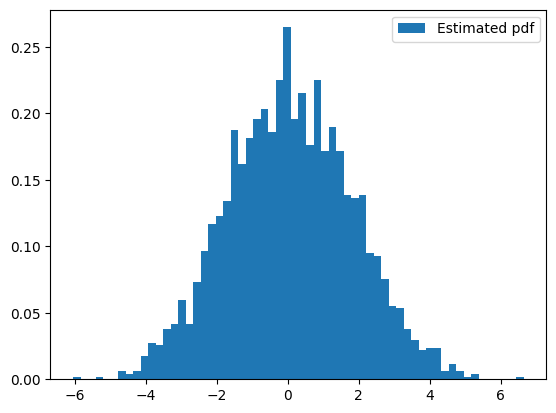

In [7]:
plt.hist(NAO_df["NAO_index"],bins=60,density=True,label="Estimated pdf")
plt.legend()
plt.show()

In [8]:
st.describe(NAO_df["NAO_index"]["1950":"1980"])

DescribeResult(nobs=372, minmax=(np.float64(-4.114), np.float64(4.544)), mean=np.float64(0.015715053763440845), variance=np.float64(2.489300382198649), skewness=np.float64(-0.02006309686841646), kurtosis=np.float64(-0.21668994293611243))

In [9]:
st.describe(NAO_df["NAO_index"]["1980":"2009"])

DescribeResult(nobs=360, minmax=(np.float64(-4.704), np.float64(5.258)), mean=np.float64(-0.00912500000000001), variance=np.float64(3.227420421657382), skewness=np.float64(0.06876776543579774), kurtosis=np.float64(-0.06559102933337302))

In [10]:
st.describe(NAO_df["NAO_index"]["2010"])

DescribeResult(nobs=12, minmax=(np.float64(-4.605), np.float64(0.062)), mean=np.float64(-2.345), variance=np.float64(1.8912969090909086), skewness=np.float64(0.056402459679996936), kurtosis=np.float64(-0.8179828357408816))

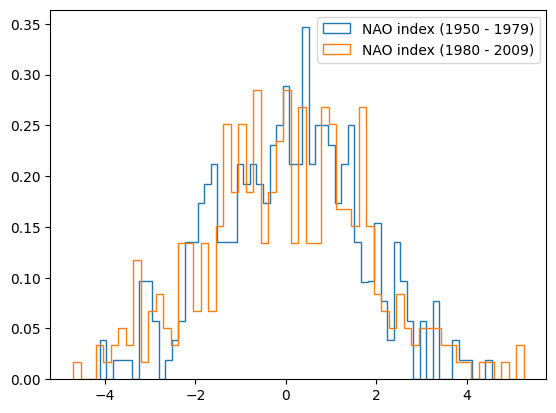

In [11]:
plt.hist(NAO_df["NAO_index"]["1950":"1979"],bins=60,histtype="step",density=True,label="NAO index (1950 - 1979)")
plt.hist(NAO_df["NAO_index"]["1980":"2009"],bins=60,histtype="step",density=True,label="NAO index (1980 - 2009)")
#plt.hist(NAO_df["nao_index_cdas"]["2010":],bins=60,histtype="step",density=True,label="NAO index (2010 - 2024(May))")
plt.legend()
plt.show()

(0.0, 500.0)

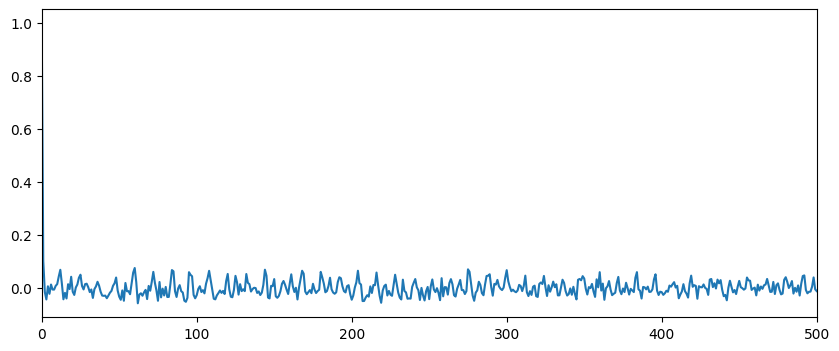

In [12]:
# autocorrelation function:
autocorr_NAO = sm.tsa.acf(NAO_df["NAO_index"], nlags=500)
plt.figure(figsize=[10,4])
plt.plot(autocorr_NAO)
plt.xlim(0,500)

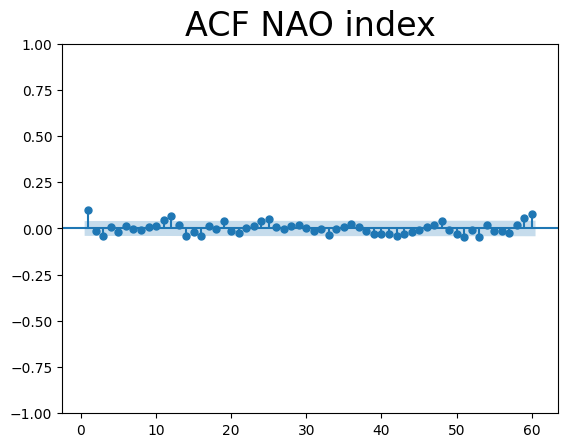

In [13]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(NAO_df["NAO_index"], lags = 60, zero = False)
plt.title("ACF NAO index", size = 24)
plt.show()

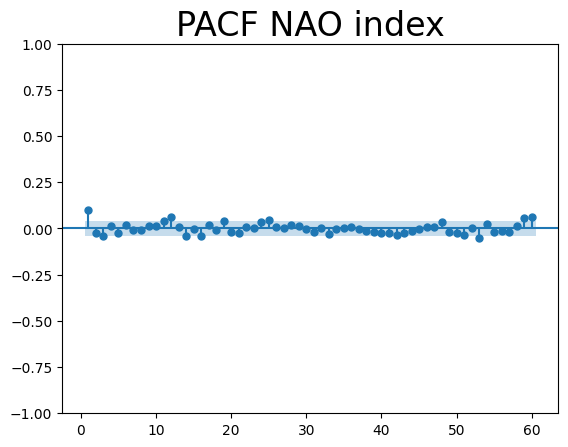

In [14]:
sgt.plot_pacf(NAO_df["NAO_index"], lags = 60, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

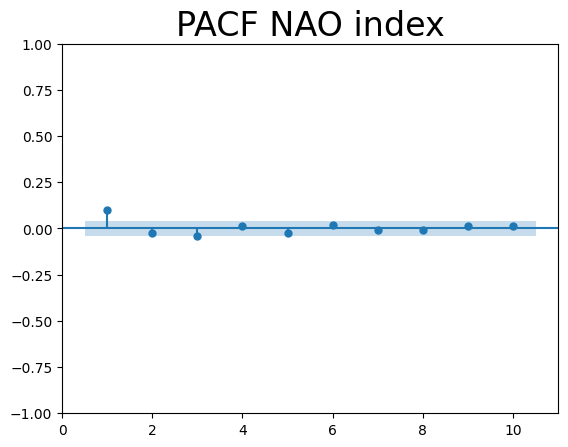

In [15]:
sgt.plot_pacf(NAO_df["NAO_index"], lags = 10, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

In [16]:
import statsmodels.tsa.stattools as sts
sts.adfuller(NAO_df["NAO_index"])

(np.float64(-28.7419177876792),
 0.0,
 2,
 2385,
 {'1%': np.float64(-3.4330948017272944),
  '5%': np.float64(-2.862752613124175),
  '10%': np.float64(-2.5674155252737014)},
 np.float64(9351.35038888947))

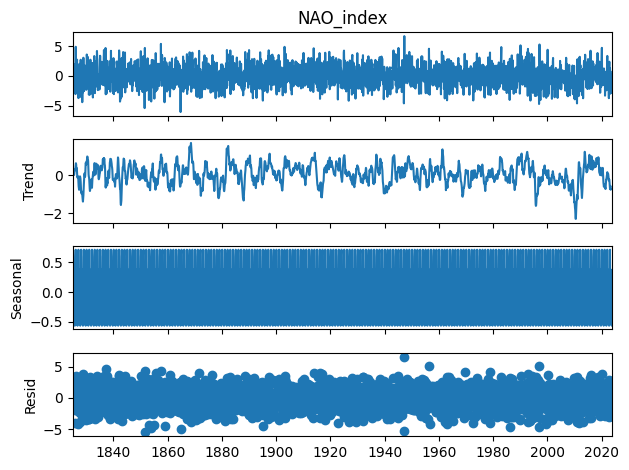

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_multiplicative = seasonal_decompose(NAO_df["NAO_index"], model = "additive")
s_dec_multiplicative.plot()
plt.show()

## Model

In [18]:
total_length = len(NAO_df)
train_length = int(total_length * 0.6)
validation_length = int(total_length * 0.2)

train_df = NAO_df.iloc[:train_length]
validation_df = NAO_df.iloc[train_length:train_length + validation_length]
test_df = NAO_df.iloc[train_length + validation_length:]

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {validation_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (1432, 1)
Validation data shape: (477, 1)
Testing data shape: (479, 1)


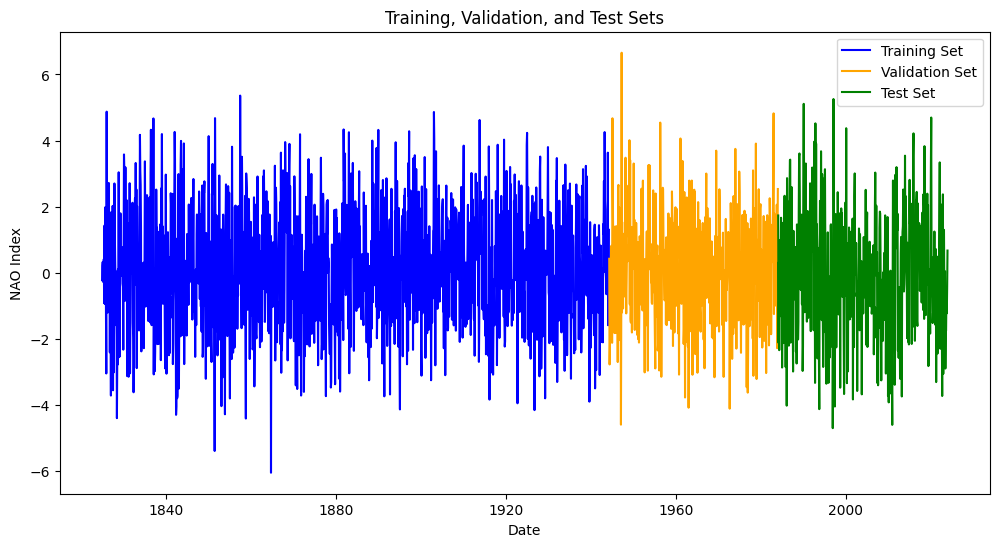

In [19]:
plt.figure(figsize=(12, 6)) 
plt.plot(train_df.index, train_df["NAO_index"], color='blue', label='Training Set')
plt.plot(validation_df.index, validation_df["NAO_index"], color='orange', label='Validation Set')
plt.plot(test_df.index, test_df["NAO_index"], color='green', label='Test Set')

plt.xlabel('Date')
plt.ylabel('NAO Index')
plt.title('Training, Validation, and Test Sets')
plt.legend()
plt.show()

In [20]:
# Normalizing data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_df['NAO_index'].values.reshape(-1, 1)).reshape(-1)
validation_scaled = scaler.transform(validation_df['NAO_index'].values.reshape(-1, 1)).reshape(-1)
test_scaled = scaler.transform(test_df['NAO_index'].values.reshape(-1, 1)).reshape(-1)

In [21]:
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data) - input_length):
        x = data[i:(i + input_length)]
        y = data[i + input_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# using 24 data to predict 1 data point
input_length = 24

X_train, y_train = create_sequences(train_scaled, input_length)
X_validation, y_validation = create_sequences(validation_scaled, input_length)
X_test, y_test = create_sequences(test_scaled, input_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_validation = X_validation.reshape((X_validation.shape[0], X_validation.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shapes: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation data shapes: X_validation {X_validation.shape}, y_validation {y_validation.shape}")
print(f"Testing data shapes: X_test {X_test.shape}, y_test {y_test.shape}")

Training data shapes: X_train (1408, 24, 1), y_train (1408,)
Validation data shapes: X_validation (453, 24, 1), y_validation (453,)
Testing data shapes: X_test (455, 24, 1), y_test (455,)


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NBeatsNet(stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  forecast_length=1,
                  backcast_length=input_length,
                  hidden_layer_units=64,
                  nb_blocks_per_stack=3,
                  device=device)

model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=24, forecast_length=1, share_thetas=False) at @5917201552
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=24, forecast_length=1, share_thetas=False) at @5917601312
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=24, forecast_length=1, share_thetas=False) at @5916443600
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=24, forecast_length=1, share_thetas=False) at @5917203280
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=24, forecast_length=1, share_thetas=False) at @5917528512
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=24, forecast_length=1, share_thetas=False) at @5917528704


In [23]:
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().unsqueeze(-1).to(device)

X_validation_tensor = torch.tensor(X_validation).float().to(device)
y_validation_tensor = torch.tensor(y_validation).float().unsqueeze(-1).to(device)

X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().unsqueeze(-1).to(device)

In [24]:
num_epochs = 50

train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(X_train_tensor)[0]
    loss_train = criterion(y_pred_train, y_train_tensor)

    loss_train.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_validation = model(X_validation_tensor)[0]
        loss_validation = criterion(y_pred_validation, y_validation_tensor)
    
    train_losses.append(loss_train.item())
    validation_losses.append(loss_validation.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_validation.item():.4f}')
    
    # Early stopping 
    if epoch > 0 and validation_losses[-1] > validation_losses[-2]:
        print(f'Validation loss stopped improving, stopping early at epoch {epoch+1}')
        break



/Users/tanja/Documents/OpenCampus/NAO_Prediction/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1408, 1])) that is different to the input size (torch.Size([1408, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/tanja/Documents/OpenCampus/NAO_Prediction/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([453, 1])) that is different to the input size (torch.Size([453, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Train Loss: 0.4775, Validation Loss: 0.4275
Epoch [20/50], Train Loss: 0.2909, Validation Loss: 0.2452
Epoch [30/50], Train Loss: 0.2023, Validation Loss: 0.1699
Epoch [40/50], Train Loss: 0.1888, Validation Loss: 0.1592
Epoch [50/50], Train Loss: 0.1808, Validation Loss: 0.1526


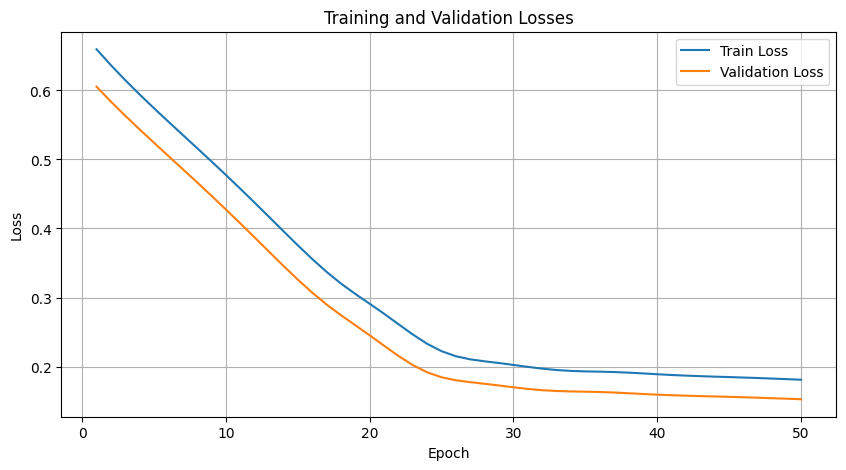

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(np.arange(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
validation_df.index

DatetimeIndex(['1944-05-01', '1944-06-01', '1944-07-01', '1944-08-01',
               '1944-09-01', '1944-10-01', '1944-11-01', '1944-12-01',
               '1945-01-01', '1945-02-01',
               ...
               '1983-04-01', '1983-05-01', '1983-06-01', '1983-07-01',
               '1983-08-01', '1983-09-01', '1983-10-01', '1983-11-01',
               '1983-12-01', '1984-01-01'],
              dtype='datetime64[ns]', name='Date', length=477, freq=None)

In [27]:
def predict_with_model(model, X_tensor):
    model.eval()
    with torch.no_grad():
        model_output = model(X_tensor)
        if isinstance(model_output, tuple):
            y_pred = model_output[0] 
        else:
            y_pred = model_output  

        y_pred = y_pred.cpu().detach().numpy()[:, -1] 
    return y_pred


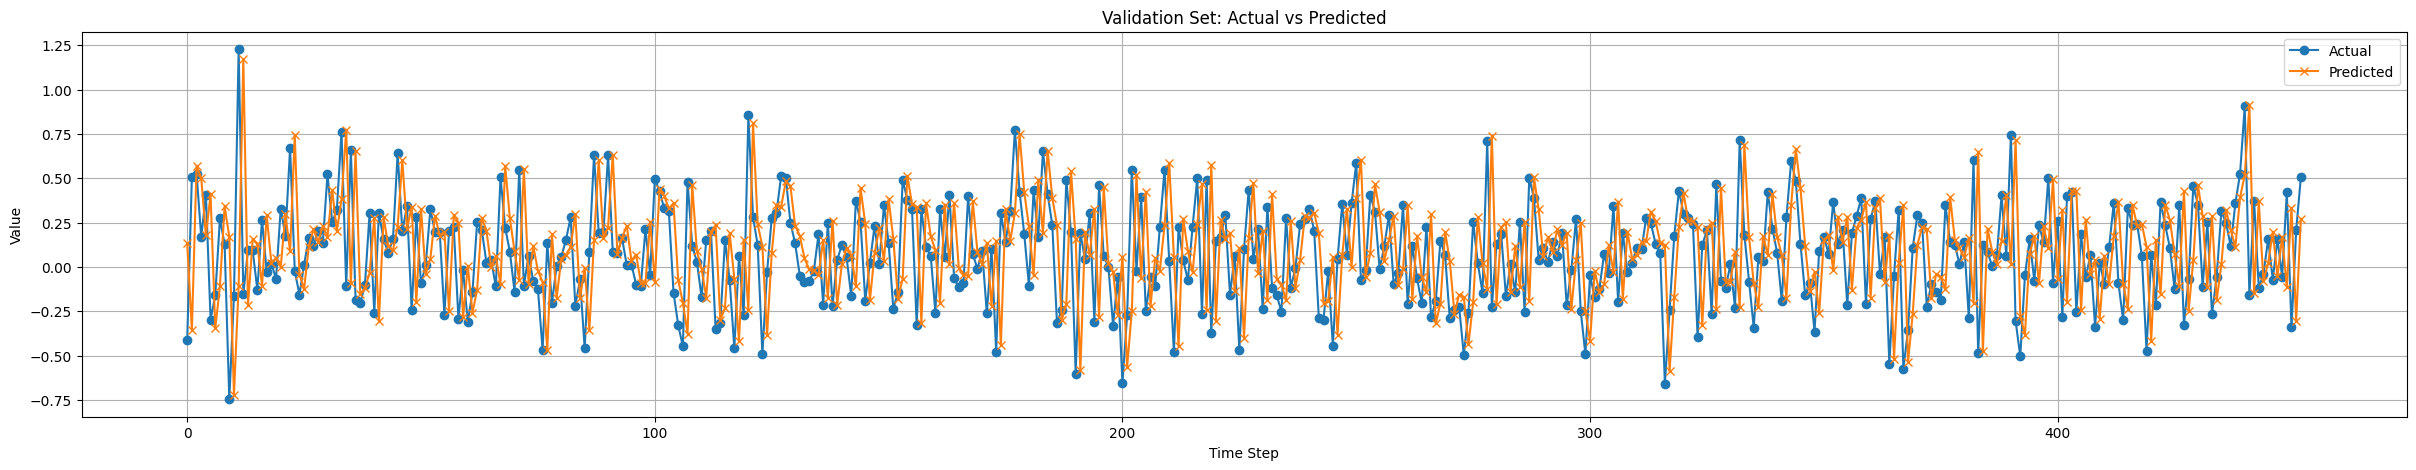

In [28]:
y_pred_validation = predict_with_model(model, X_validation_tensor)
# Plot actual vs predicted values
plt.figure(figsize=(30, 5))
plt.plot(y_validation, label='Actual', marker='o')
plt.plot(y_pred_validation, label='Predicted', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Validation Set: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

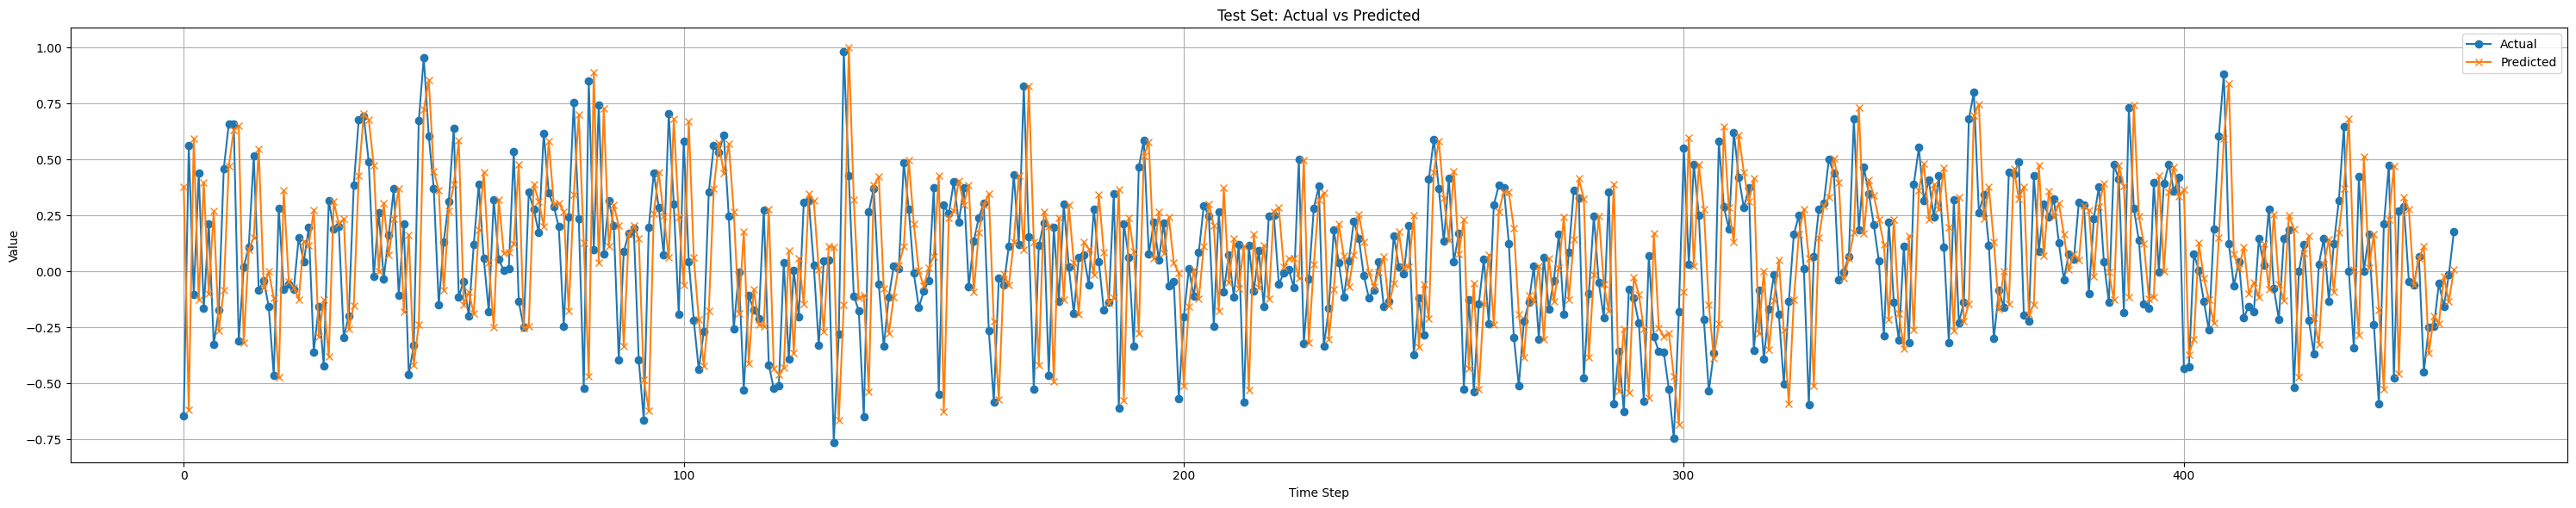

In [29]:
y_pred_test = predict_with_model(model, X_test_tensor)

# Plot actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred_test, label='Predicted', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:

print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred_test: {y_pred_test.shape}")

Shape of y_test: (455,)
Shape of y_pred_test: (455,)


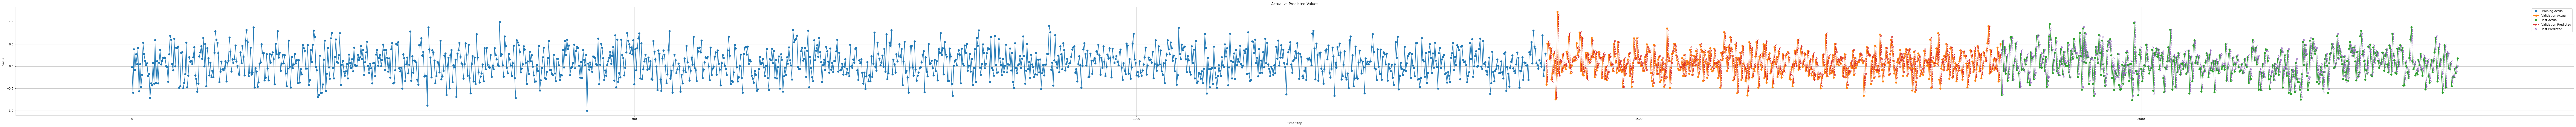

In [31]:

# Plotting
plt.figure(figsize=(120, 6))

# Plotting actual values
plt.plot(np.arange(len(y_train)), y_train, label='Training Actual', marker='o', linestyle='-')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_validation)), y_validation, label='Validation Actual', marker='o', linestyle='-')
plt.plot(np.arange(len(y_train) + len(y_validation), len(y_train) + len(y_validation) + len(y_test)), y_test, label='Test Actual', marker='o', linestyle='-')

# Plotting predicted values for validation set
plt.plot(np.arange(len(y_train), len(y_train) + len(y_validation)), y_pred_validation, label='Validation Predicted', marker='x', linestyle='--')

# Plotting predicted values for test set
plt.plot(np.arange(len(y_train) + len(y_validation), len(y_train) + len(y_validation) + len(y_test)), y_pred_test, label='Test Predicted', marker='x', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
def phase_check(y_test,y_pred):
  """
  Args:
    y_test
    y_pred
  Returns: phase agreement of the two time series in percentage
  """
  #check for phases in y_test and y_pred:
  y_test_phases = np.zeros(len(y_test))
  y_pred_phases = np.zeros(len(y_pred))
  negative_test = np.where(y_test <-1)[0]# currently everything between -1 and 1 is set to neutral (might have to rethink tis interval)
  negative_pred = np.where(y_pred <-1)[0]
  positive_test = np.where(y_test >1)[0]
  positive_pred = np.where(y_pred >1)[0]
  y_test_phases[negative_test] = -1
  y_pred_phases[negative_pred] = -1
  y_test_phases[positive_test] = 1
  y_pred_phases[positive_pred] = 1
  counter = np.sum(y_test_phases==y_pred_phases)
  phase_percent = 100/len(y_test) * counter
  return phase_percent

In [33]:
phase_percent = phase_check(y_test, y_pred_test)
phase_percent

np.float64(99.78021978021978)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

mae_validation = mean_absolute_error(y_validation, y_pred_validation)
mae_test = mean_absolute_error(y_test, y_pred_test)

mse_validation = mean_squared_error(y_validation, y_pred_validation)
mse_test = mean_squared_error(y_test, y_pred_test)

medae_validation = median_absolute_error(y_validation, y_pred_validation)
medae_test = median_absolute_error(y_test, y_pred_test)

# Print results
print(f"Metrics for Validation Set:")
print(f"Mean absolute error: {mae_validation:.4f}")
print(f"Mean squared error: {mse_validation:.4f}")
print(f"Median Absolute Error: {medae_validation:.4f}")
print()
print(f"Metrics for Test Set:")
#print(f"Mean absolute error: {mae_test:.4f}")
print(f"Mean squared error: {mse_test:.4f}")
#print(f"Median Absolute Error: {medae_test:.4f}")
print(f"Phase Percent: {phase_percent:.4f}")

Metrics for Validation Set:
Mean absolute error: 0.3173
Mean squared error: 0.1568
Median Absolute Error: 0.2684

Metrics for Test Set:
Mean squared error: 0.1583
Phase Percent: 99.7802
